<a href="https://colab.research.google.com/github/wkweigel/NotebookExamples/blob/main/FingerprintAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

In [1]:
!pip install rdkit

import sys

#Clone main repository into colab
!git clone https://github.com/wkweigel/NotebookExamples.git

#Add the main directory to the path
main_dir = '/content/NotebookExamples'
sys.path.insert(0,f'{main_dir}/')



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 13.3 MB/s eta 0:00:00
Cloning into 'NotebookExamples'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 274 (delta 87), reused 135 (delta 77), pack-reused 116 (from 1)
Receiving objects: 100% (274/274), 16.75 MiB | 9.55 MiB/s, done.
Resolving deltas: 100% (140/140), done.


# Library Imports

In [13]:
from Modules.FingerprintAnalysisTools import*
import pandas as pd
from rdkit.Chem import  PandasTools
from itertools import combinations
from rdkit import rdBase
blocker = rdBase.BlockLogs()

# Load Data
 * This data comes from a combinatorial library made from two building block pools.
 * The subset of data we will use share a common building block (A045 in this case).

In [7]:
data_df = pd.read_csv('/content/NotebookExamples/Datasets/Smiles.csv')

#Define a boolean mask to get the rows with common BB A
bb_mask = data_df.apply(lambda row: row.astype(str).str.contains('A025').any(), axis=1)

#Apply the mask
bbA_df = data_df[bb_mask]
bbA_df.head()

,Unnamed: 0,id,smiles
123,8908,A025_B053,CNC([C@H](CNC(Cn1ncc(S(N)(=O)=O)c1)=O)NC(CCc(c...
243,8969,A025_B114,CNC([C@H](CNC(Cn1ncc(S(N)(=O)=O)c1)=O)NC(COc(c...
334,8905,A025_B050,CNC([C@H](CNC(Cn1ncc(S(N)(=O)=O)c1)=O)NC(Cc(cc...
480,9130,A025_B275,CNC([C@H](CNC(Cn1ncc(S(N)(=O)=O)c1)=O)NC(c(cc1...
486,9150,A025_B295,CNC([C@H](CNC(Cn1ncc(S(N)(=O)=O)c1)=O)NC(c1ncc...


# Sample the Data
* Take 10 compounds for fingerprint analysis.

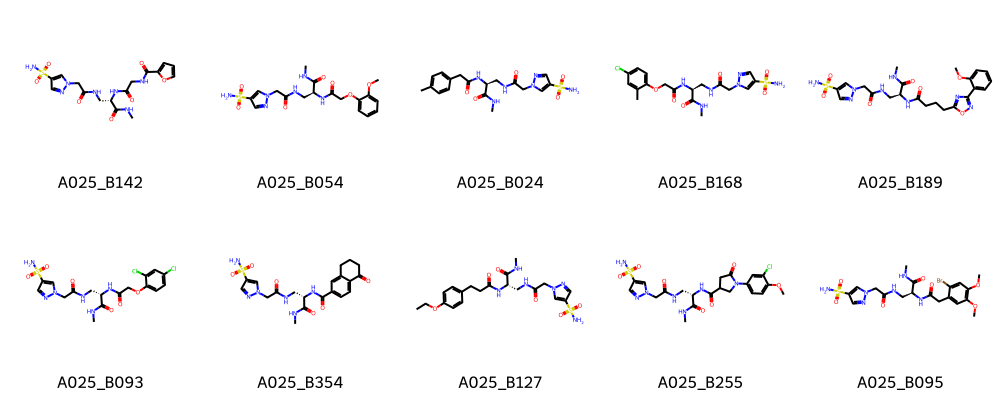

In [12]:
#Take a small sample for analysis
sample_df = bbA_df.sample(10)

#Use PandasTools to add mols to the sample_df
PandasTools.AddMoleculeColumnToFrame(sample_df, "smiles", "Mols")

# Preview the compounds
PandasTools.FrameToGridImage(sample_df, column='Mols', legendsCol="id", molsPerRow=5)

# Fingerprint the Data

In [16]:
from rdkit import rdBase
blocker = rdBase.BlockLogs() # For silencing depreciation warnings

#Define the fp types to test
fp_types=['rdkit', 'fMorgan', 'gobbi', 'ecfp', 'torsion', 'avalon', 'atompair']

#Create a dictionary of the sampled data
testing_dict=dict(zip(sample_df['id'].tolist(), sample_df['smiles'].tolist()))

#Create a lists for the test IDs and ID pairs
test_IDs=list(testing_dict.keys())
test_pairs= list(combinations(test_IDs, 2))

#Calculate the fps for each type store as a dataframe
fp_df=pd.DataFrame()
fp_df['ID']=test_IDs

for fp_type in fp_types:
    fp_list=[]
    for ID in test_IDs:
        fp = get_single_FP_from_smiles(testing_dict[ID], fp_type=fp_type, nBits=1024)
        fp_str=''.join(str(bit) for bit in fp)
        fp_list.append(fp_str)
    fp_df[fp_type]=fp_list

# Visualize the Fingerprints
* Compare diffrent fingerprinting methods using compound pairs.


In [17]:
@interact(pair_index=(0, len(test_pairs)-1, 1), fp_type=fp_types)
def show_pair(pair_index=0, fp_type='fMorgan'):
    pair = test_pairs[pair_index]
    mol1 = Chem.MolFromSmiles(testing_dict[pair[0]])
    mol2 = Chem.MolFromSmiles(testing_dict[pair[1]])
    id1 = pair[0]
    id2 = pair[1]
    row_idx1 = fp_df.index[fp_df['ID'] == id1].tolist()[0]
    row_idx2 = fp_df.index[fp_df['ID'] == id2].tolist()[0]
    legends = [id1, id2]

    print('Adjust the pair_index slider with the mouse or select the slider and and use the arrow keys \n')
    print('<<BIT STRING GRIDS>>')

    fp1 = fp_df.iloc[row_idx1][fp_type]
    fp2 = fp_df.iloc[row_idx2][fp_type]
    display_bitstrings(fp1, fp2, id1, id2)

    return MolsToGridImage([mol1, mol2], molsPerRow=2, subImgSize=(475, 475), legends=legends)

interactive(children=(IntSlider(value=0, description='pair_index', max=44), Dropdown(description='fp_type', in…

# Similarity Comparison
 * Compare Tanimoto similarities for the diffrent fingerprints.

In [18]:
from rdkit.Chem import rdFMCS

@interact(pair_index=(0,len(test_pairs),1)) #control with a slider
def show_pair(pair_index=0):
    pair = test_pairs[pair_index]
    mol1 = Chem.MolFromSmiles(testing_dict[pair[0]])
    mol2 = Chem.MolFromSmiles(testing_dict[pair[1]])
    id1 = pair[0]
    id2 = pair[1]
    row_idx1=fp_df.index[fp_df['ID']==id1].tolist()[0]
    row_idx2=fp_df.index[fp_df['ID']==id2].tolist()[0]
    legends = [id1, id2]

    print('Adjust the pair_index slider with the mouse or select the slider and and use the arrow keys \n')
    print('<<TANIMOTO SCORES>>')
    for fp_type in fp_types:
        fp1 = DataStructs.CreateFromBitString(fp_df.iloc[row_idx1][fp_type])
        fp2 = DataStructs.CreateFromBitString(fp_df.iloc[row_idx2][fp_type])
        print(f'{fp_type}: {DataStructs.TanimotoSimilarity(fp1, fp2):.3f}')

    return MolsToGridImage([mol1,mol2],molsPerRow=2,subImgSize=(400, 400),legends=legends)

interactive(children=(IntSlider(value=0, description='pair_index', max=45), Output()), _dom_classes=('widget-i…